In [1]:
using IntervalArithmetic
using LaTeXStrings
using Plots

In [2]:
include("./heatmap/index.jl")
include("./method1/index.jl")
include("./method2/index.jl")
include("./method3/index.jl")
include("./method4/index.jl")
include("./intervalPCM/index.jl")
include("./twofoldInterval/index.jl")
include("./twofoldIntervalPCM/index.jl")

print()

In [4]:
function method1(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    A = intervalPCM2TwofoldIntervalPCM(A₁, A₂)
    result = solveLP_m1(A)
    Â = updatePCM_m1(A, result)
    return Â
end

method1 (generic function with 1 method)

In [5]:
function  method2(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    εᶿ = solveIndividualCancellingLP_m2([A₁, A₂])
    result = solveApproximationLP_m2([A₁, A₂], εᶿ)
    A = importance2TwofoldIntervalPCM_m2(result)
    return A
end

method2 (generic function with 1 method)

In [6]:
function method3(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    approximationResults = solveApproximationLP_m3.([A₁, A₂])
    tBoundaries = calculateTBoundaries_m3.(approximationResults)
    result = solveConcatLP_m3(approximationResults, tBoundaries)
    Â = generatePCM_m3(result)
    return Â
end

method3 (generic function with 1 method)

In [7]:
function method4(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}) where {T <: Real}
    results = solveApproximationLP_m4.([A₁, A₂])
    A = generateTwofoldIntervalMatrix_m4(results)
    result = solveCancellingLP_m4(A)
    Â = updatePCM_m4(A, result)
    return Â
end

method4 (generic function with 1 method)

In [8]:
# 対角成分以外の算術平均
function mean(A::Matrix{T})::T where {T <: Real}
    m, n = size(A)

    if m != n return 0 end
    if n == 1 return 0 end

    a = 0
    for i = 1:m, j = 1:n
        if i == j continue end
        a += A[i,j]
    end

    return a / n / (n-1)
end

titles = [
    "行列を結合して二重区間PCMを作り，整合化",
    "整合化しながら結合した重要度を求めて二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする",
    "DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"
]

function plotAll(A₁::Matrix{Interval{T}}, A₂::Matrix{Interval{T}}, size::Tuple{Integer, Integer}=(1000, 250)) where {T <: Real}
    m = 2 # DM の数

    matrices = [A₁, A₂]
    resultMatrices = twofoldIntervalMatrix2intervalMatrices.(
        [method1(A₁, A₂), method2(A₁, A₂), method3(A₁, A₂), method4(A₁, A₂)])
    
    p = []; a = []; indmat = []
    for k = 1:length(resultMatrices)
        h = []; indrow = []
        Âₖ⁻, Âₖ⁺ = resultMatrices[k]
        for l = 1:m
            title⁻ = L"\frac{\left| A_{%$(l)ij} \cap \hat{A}_{%$(k)ij}^- \right|}{\left| A_{%$(l)ij} \cup \hat{A}_{%$(k)ij}^- \right|}"
            title⁺ = L"\frac{\left| A_{%$(l)ij} \cap \hat{A}_{%$(k)ij}^+ \right|}{\left| A_{%$(l)ij} \cup \hat{A}_{%$(k)ij}^+ \right|}"

            heatmap⁻, indices⁻ = plotConincidenceIndices(matrices[l], Âₖ⁻, title⁻)
            heatmap⁺, indices⁺ = plotConincidenceIndices(matrices[l], Âₖ⁺, title⁺)

            push!(h, heatmap⁻); push!(h, heatmap⁺)
            push!(indrow, indices⁻); push!(indrow, indices⁺)
        end

        push!(p, h); push!(a, [Âₖ⁻, Âₖ⁺])
        push!(indmat, indrow)
    end

    for i = eachindex(p)
        display(titles[i])
        A = intervalPCM2TwofoldIntervalPCM(a[i][1], a[i][2])
        display(L"\hat{A}_{%$(i)} = %$(twofoldIntervalMatrixLaTeXString(A))")
        display(plot(p[i]..., layout=(1, 4), size=size, legend=false))
        display("非対角成分の算術平均: $(round(mean(indmat[i][1]), digits=3)), $(round(mean(indmat[i][2]), digits=3)), $(round(mean(indmat[i][3]), digits=3)), $(round(mean(indmat[i][4]), digits=3))")
    end
end

plotAll (generic function with 2 methods)

## 区間の整合性

https://www.sciencedirect.com/science/article/abs/pii/S0360835217302929?via%3Dihub

### 定義

任意の $i, j, k \in N$ において，任意の $a_{ij} \in \left[ a_{ij}^\text{L}, a_{ij}^\text{U} \right]$ について $a_{ij} = a_{ik} a_{kj}$ となるような $a_{ik} \in \left[ a_{ik}^\text{L}, a_{ik}^\text{U} \right], a_{kj} \in \left[ a_{kj}^\text{L}, a_{kj}^\text{U} \right]$ が存在するならば，  
$A = \left( \left[ a_{ij}^\text{L}, a_{ij}^\text{U} \right] \right)_{n \times n}$ は整合している．

### 必要十分条件

任意の $i, j \in N, ~ i < j$ において， $a_{ij}^\text{L} \geq \max_{k \in N} a_{ik}^\text{L} a_{kj}^\text{L}$ かつ $a_{ij}^\text{U} \leq \min_{k \in N} a_{ik}^\text{U} a_{kj}^\text{U}$ であるならば，  
$A = \left( \left[ a_{ij}^\text{L}, a_{ij}^\text{U} \right] \right)_{n \times n}$ は整合している．

## 区間の整合性

https://www.sciencedirect.com/science/article/pii/S0377221715008346?via%3Dihub

### 定義

任意の $i, j, k \in N$ において $A_{ij} A_{jl} A_{ki} = A_{ki} A_{kj} A_{ji}$ であるならば，  
$A = \left( \left[ a_{ij}^\text{L}, a_{ij}^\text{U} \right] \right)_{n \times n}$ は整合している．

また，次の関係が成り立つ．
$$
\begin{align*}
& \text{任意の} i, j, k \in N \text{において}
a_{ij} a_{jk} a_{ki} = a_{ki} a_{kj} a_{ji} \\
\Leftrightarrow ~~ & i < j < k \text{を満たす全ての} i, j, k \in N \text{において}
a_{ij}^\text{L} a_{ij}^\text{U} = a_{ik}^\text{L} a_{ik}^\text{U} a_{kj}^\text{L} a_{kj}^\text{U}
\end{align*}
$$

整合している同じ行列 2 つ

L"$A_1 = A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] & \left[ 8.41, 9.61 \right] & \left[ 8.41, 9.61 \right] \\ \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] & \left[ 2.9, 3.1 \right] \\ \left[ 0.104, 0.119 \right] & \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \\ \left[ 0.104, 0.119 \right] & \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[   2.9,   2.9 \\right],   3.1 \\right] & \\left[  8.41, \\left[  8.41,  8.41 \\right],  9.61 \\right] & \\left[  8.41, \\left[  8.41,  8.41 \\right],  9.61 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.143 \\right] \\\\ \\left[ 0.104, \\left[ 0.119, 0.119 \\right], 0.119 \\right] & \\left[ 0.302, \\left[ 0.345, 0.345 \\right], 0.369 \\right] & \\left[ 0.875, \\left[   1.0,   1.0 \\right], 1.143 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

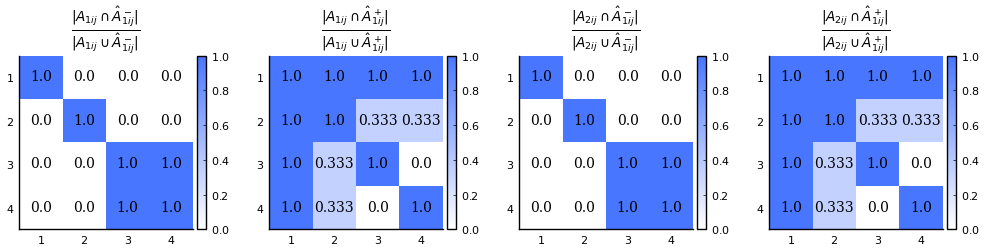

"非対角成分の算術平均: 0.167, 0.611, 0.167, 0.611"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[   2.9,   3.1 \\right],   3.1 \\right] & \\left[  8.41, \\left[   8.9,  9.05 \\right],  9.61 \\right] & \\left[  8.41, \\left[   8.9,  9.05 \\right],  9.61 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.124 \\right] \\\\ \\left[ 0.104, \\left[  0.11, 0.112 \\right], 0.119 \\right] & \\left[ 0.307, \\left[ 0.326, 0.343 \\right], 0.363 \\right] & \\left[  0.89, \\left[   1.0,   1.0 \\right], 1.124 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

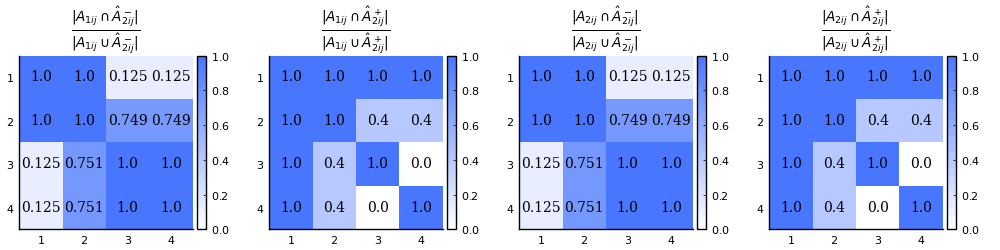

"非対角成分の算術平均: 0.625, 0.633, 0.625, 0.633"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[ 2.955, 2.955 \\right], 2.955 \\right] & \\left[ 9.162, \\left[ 9.162, 9.162 \\right],  9.61 \\right] & \\left[ 8.859, \\left[ 9.162, 9.162 \\right],  9.61 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.049 \\right] \\\\ \\left[ 0.104, \\left[ 0.109, 0.109 \\right], 0.113 \\right] & \\left[ 0.308, \\left[ 0.317, 0.323 \\right], 0.334 \\right] & \\left[ 0.953, \\left[   1.0, 1.034 \\right], 1.049 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

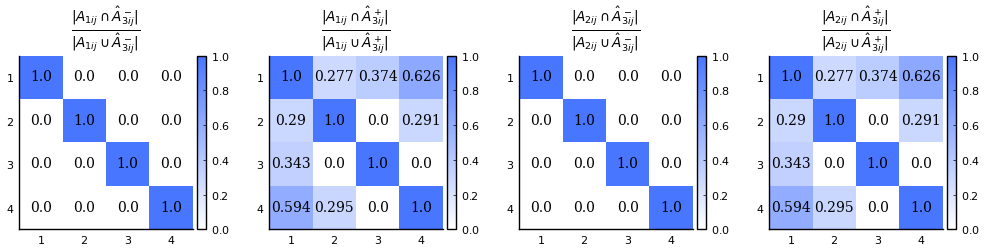

"非対角成分の算術平均: 0.0, 0.257, 0.0, 0.257"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[ 2.955, 2.955 \\right],   3.1 \\right] & \\left[  8.41, \\left[ 9.162, 9.162 \\right],  9.61 \\right] & \\left[  8.41, \\left[ 9.162, 9.162 \\right],  9.61 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.143 \\right] \\\\ \\left[ 0.104, \\left[ 0.109, 0.109 \\right], 0.119 \\right] & \\left[ 0.302, \\left[ 0.323, 0.323 \\right], 0.369 \\right] & \\left[ 0.875, \\left[   1.0,   1.0 \\right], 1.143 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

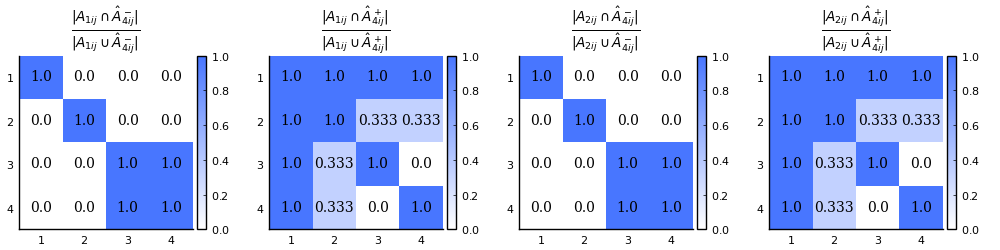

"非対角成分の算術平均: 0.167, 0.611, 0.167, 0.611"

In [41]:
A₁ = [
    1..1 2.9..3.1 2.9^2..3.1^2 2.9^2..3.1^2
    (1/3.1)..(1/2.9) 1..1 2.9..3.1 2.9..3.1
    (1/3.1)^2..(1/2.9)^2 (1/3.1)..(1/2.9) 1..1 1..1
    (1/3.1)^2..(1/2.9)^2 (1/3.1)..(1/2.9) 1..1 1..1
]
A₂ = A₁

display(L"A_1 = A_2 = %$(intervalMatrixLaTeXString(A₁))")

plotAll(A₁, A₂)

ともに整合していて， $A_{1ij} \subseteq A_{2ij}$

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] & \left[ 8.41, 9.61 \right] & \left[ 8.41, 9.61 \right] \\ \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.9, 3.1 \right] & \left[ 2.9, 3.1 \right] \\ \left[ 0.104, 0.119 \right] & \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \\ \left[ 0.104, 0.119 \right] & \left[ 0.323, 0.345 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 2.85, 3.15 \right] & \left[ 8.122, 9.923 \right] & \left[ 8.122, 9.923 \right] \\ \left[ 0.317, 0.351 \right] & \left[ 1.0, 1.0 \right] & \left[ 2.85, 3.15 \right] & \left[ 2.85, 3.15 \right] \\ \left[ 0.101, 0.123 \right] & \left[ 0.317, 0.351 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \\ \left[ 0.101, 0.123 \right] & \left[ 0.317, 0.351 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

true

true

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\left[   2.9,   2.9 \\right],  3.15 \\right] & \\left[ 8.122, \\left[  8.41,  8.41 \\right], 9.923 \\right] & \\left[ 8.122, \\left[  8.41,  8.41 \\right], 9.923 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.143 \\right] \\\\ \\left[ 0.101, \\left[ 0.119, 0.119 \\right], 0.123 \\right] & \\left[ 0.302, \\left[ 0.345, 0.345 \\right], 0.369 \\right] & \\left[ 0.875, \\left[   1.0,   1.0 \\right], 1.143 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

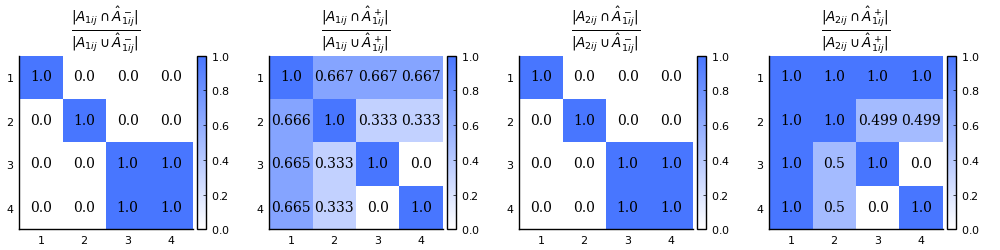

"非対角成分の算術平均: 0.167, 0.444, 0.167, 0.667"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\left[   2.9,   3.1 \\right],  3.15 \\right] & \\left[ 8.122, \\left[ 8.849, 8.998 \\right], 9.923 \\right] & \\left[ 8.122, \\left[ 8.849, 8.998 \\right], 9.923 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.201 \\right] \\\\ \\left[ 0.101, \\left[ 0.111, 0.113 \\right], 0.123 \\right] & \\left[ 0.292, \\left[ 0.328, 0.345 \\right], 0.381 \\right] & \\left[ 0.832, \\left[   1.0,   1.0 \\right], 1.201 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

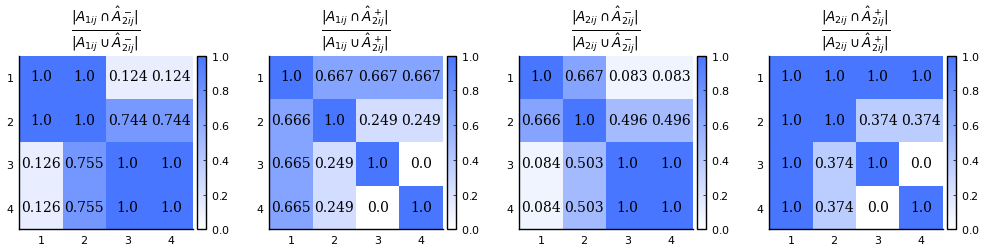

"非対角成分の算術平均: 0.625, 0.416, 0.472, 0.625"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[   2.9, \\left[  2.93, 2.955 \\right], 2.995 \\right] & \\left[ 9.153, \\left[ 9.153, 9.237 \\right], 9.619 \\right] & \\left[  8.41, \\left[ 9.153, 9.237 \\right], 9.619 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.008 \\right] \\\\ \\left[ 0.104, \\left[ 0.108, 0.109 \\right], 0.119 \\right] & \\left[ 0.307, \\left[ 0.314, 0.327 \\right], 0.351 \\right] & \\left[ 0.992, \\left[ 0.992,  1.05 \\right], 1.143 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

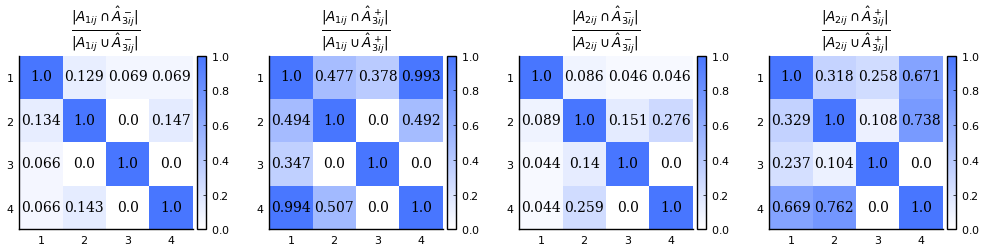

"非対角成分の算術平均: 0.069, 0.39, 0.098, 0.35"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[  2.85, \\emptyset,  3.15 \\right] & \\left[ 8.123, \\emptyset, 9.923 \\right] & \\left[ 8.123, \\emptyset, 9.923 \\right] \\\\ \\left[ 0.317, \\emptyset, 0.351 \\right] & \\left[   1.0, \\l" ⋯ 269 bytes ⋯ "eft[ 0.819, \\left[   1.0,   1.0 \\right], 1.222 \\right] \\\\ \\left[ 0.101, \\emptyset, 0.123 \\right] & \\left[ 0.287, \\emptyset, 0.388 \\right] & \\left[ 0.819, \\left[   1.0,   1.0 \\right], 1.222 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

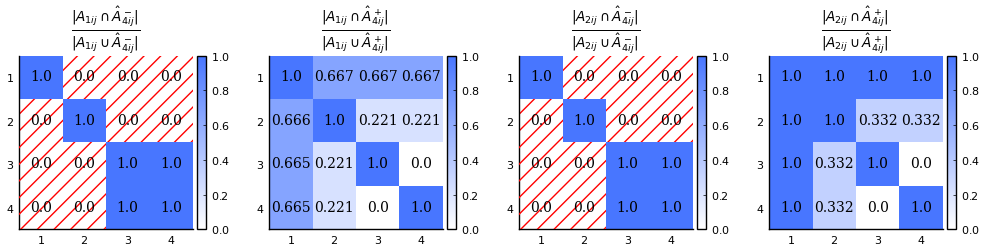

"非対角成分の算術平均: 0.167, 0.407, 0.167, 0.611"

In [33]:
A₁ = [
    1..1 2.9..3.1 2.9^2..3.1^2 2.9^2..3.1^2
    (1/3.1)..(1/2.9) 1..1 2.9..3.1 2.9..3.1
    (1/3.1)^2..(1/2.9)^2 (1/3.1)..(1/2.9) 1..1 1..1
    (1/3.1)^2..(1/2.9)^2 (1/3.1)..(1/2.9) 1..1 1..1
]
A₂ = [
    1..1 2.85..3.15 2.85^2..3.15^2 2.85^2..3.15^2
    (1/3.15)..(1/2.85) 1..1 2.85..3.15 2.85..3.15
    (1/3.15)^2..(1/2.85)^2 (1/3.15)..(1/2.85) 1..1 1..1
    (1/3.15)^2..(1/2.85)^2 (1/3.15)..(1/2.85) 1..1 1..1
]

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

<!-- ともに弱い整合性を持ち， $A_{1ij} \subseteq A_{2ij}$

```
A₁ = [
    1..1 2..5 2..4 2..3
    (1/5)..(1/2) 1..1 (1/5)..4 (1/5)..3
    (1/4)..(1/2) (1/4)..5 1..1 (1/4)..3
    (1/3)..(1/2) (1/3)..5 (1/3)..4 1..1
]
A₂ = fill(1..1, size(A₁))
_, n = size(A₁)
for i = 1:n, j = 1:n
    if i == j continue end
    A₂[i,j] = (A₁[i,j].lo * 1/1.1)..(A₁[i,j].hi * 1.1)
end

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₁))
display(isConsistentIntervalPCM(A₂))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)
``` -->

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列　2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.03]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.981, 2.033 \right] & \left[ 3.974, 4.109 \right] & \left[ 3.958, 4.048 \right] \\ \left[ 0.492, 0.505 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.944, 2.048 \right] & \left[ 1.971, 2.045 \right] \\ \left[ 0.243, 0.252 \right] & \left[ 0.488, 0.515 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.983, 1.022 \right] \\ \left[ 0.247, 0.253 \right] & \left[ 0.489, 0.507 \right] & \left[ 0.978, 1.017 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.998, 2.01 \right] & \left[ 3.974, 4.05 \right] & \left[ 3.962, 4.041 \right] \\ \left[ 0.497, 0.5 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.945, 2.015 \right] & \left[ 1.942, 2.033 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.496, 0.514 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.972, 1.021 \right] \\ \left[ 0.247, 0.252 \right] & \left[ 0.492, 0.515 \right] & \left[ 0.979, 1.029 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\left[ 1.998, 1.998 \\right], 2.043 \\right] & \\left[ 3.911, \\emptyset, 4.109 \\right] & \\left[ 3.958, \\left[ 3.962, 3.962 \\right], 4.061 \\right] \\\\ \\left[  0.49, \\left[ " ⋯ 413 bytes ⋯ "ht], 1.035 \\right] \\\\ \\left[ 0.246, \\left[ 0.252, 0.252 \\right], 0.253 \\right] & \\left[ 0.489, \\left[ 0.504, 0.504 \\right], 0.516 \\right] & \\left[ 0.966, \\left[ 1.003, 1.003 \\right], 1.029 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

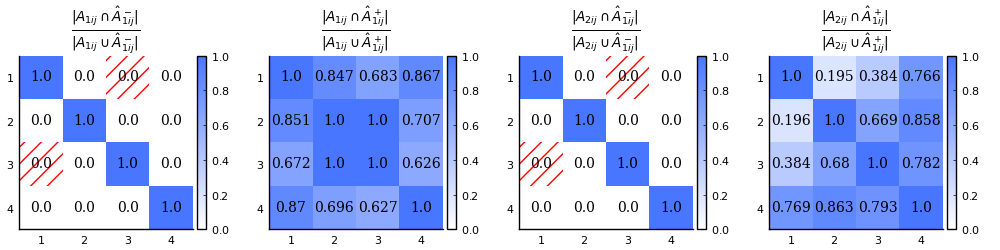

"非対角成分の算術平均: 0.0, 0.787, 0.0, 0.612"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.977, \\left[   2.0,  2.01 \\right], 2.033 \\right] & \\left[ 3.948, \\left[ 3.974, 4.031 \\right], 4.109 \\right] & \\left[ 3.944, \\left[ 3.962, 4.041 \\right], 4.048 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.024 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.252 \\right], 0.254 \\right] & \\left[ 0.489, \\left[ 0.495, 0.507 \\right], 0.515 \\right] & \\left[ 0.976, \\left[ 0.983, 1.017 \\right], 1.041 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

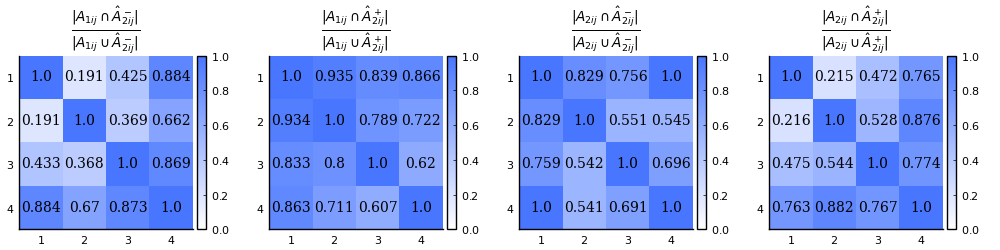

"非対角成分の算術平均: 0.568, 0.793, 0.728, 0.606"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.998, \\left[ 2.008, 2.009 \\right], 2.028 \\right] & \\left[ 3.952, \\left[ 3.972, 3.976 \\right], 4.051 \\right] & \\left[ 3.958, \\left[ 4.041, 4.048 \\right], 4.053 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.024 \\right] \\\\ \\left[ 0.247, \\left[ 0.247, 0.247 \\right], 0.253 \\right] & \\left[ 0.494, \\left[ 0.496, 0.502 \\right], 0.512 \\right] & \\left[ 0.977, \\left[ 0.981, 0.999 \\right], 1.023 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

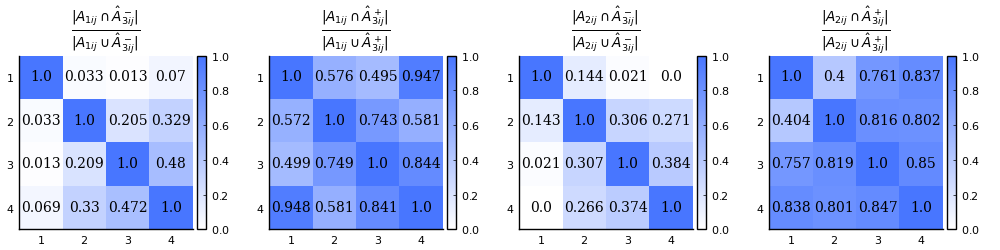

"非対角成分の算術平均: 0.188, 0.698, 0.186, 0.744"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.981, \\emptyset, 2.033 \\right] & \\left[ 3.944, \\emptyset, 4.109 \\right] & \\left[ 3.937, \\emptyset, 4.061 \\right] \\\\ \\left[ 0.492, \\emptyset, 0.505 \\right] & \\left[   1.0, \\l" ⋯ 233 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 0.963, \\emptyset,  1.03 \\right] \\\\ \\left[ 0.246, \\emptyset, 0.254 \\right] & \\left[ 0.489, \\emptyset, 0.515 \\right] & \\left[ 0.971, \\emptyset, 1.038 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

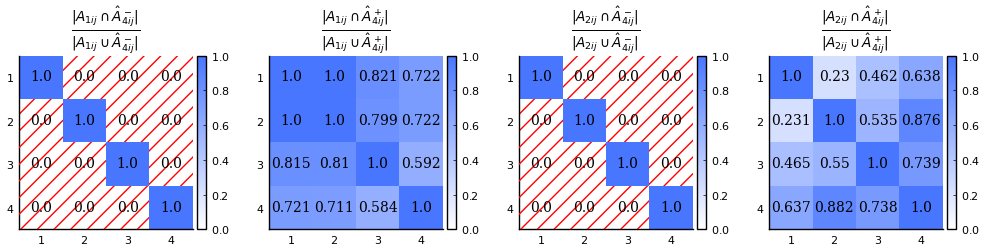

"非対角成分の算術平均: 0.0, 0.775, 0.0, 0.582"

In [27]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 1234, 3e-2)
A₂ = randamizedIntervalPCM(A, 134, 3e-2)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列 2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 0.3]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

L"$A_1 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.564, 2.231 \right] & \left[ 3.102, 4.959 \right] & \left[ 3.625, 4.692 \right] \\ \left[ 0.448, 0.639 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.523, 2.056 \right] & \left[ 1.901, 2.608 \right] \\ \left[ 0.202, 0.322 \right] & \left[ 0.486, 0.657 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.975, 1.144 \right] \\ \left[ 0.213, 0.276 \right] & \left[ 0.383, 0.526 \right] & \left[ 0.874, 1.026 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

L"$A_2 = \begin{bmatrix} \left[ 1.0, 1.0 \right] & \left[ 1.814, 2.358 \right] & \left[ 3.746, 5.231 \right] & \left[ 3.598, 4.502 \right] \\ \left[ 0.424, 0.551 \right] & \left[ 1.0, 1.0 \right] & \left[ 1.503, 2.539 \right] & \left[ 1.724, 2.503 \right] \\ \left[ 0.191, 0.267 \right] & \left[ 0.394, 0.666 \right] & \left[ 1.0, 1.0 \right] & \left[ 0.841, 1.244 \right] \\ \left[ 0.222, 0.278 \right] & \left[ 0.399, 0.58 \right] & \left[ 0.804, 1.189 \right] & \left[ 1.0, 1.0 \right] \end{bmatrix}$"

false

false

"行列を結合して二重区間PCMを作り，整合化"

"\$\\hat{A}_{1} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\left[ 1.814, 1.814 \\right], 2.358 \\right] & \\left[ 3.102, \\emptyset, 5.231 \\right] & \\left[ 3.598, \\left[ 3.625, 3.625 \\right], 4.692 \\right] \\\\ \\left[ 0.424, \\left[ " ⋯ 413 bytes ⋯ "ht], 1.337 \\right] \\\\ \\left[ 0.213, \\left[ 0.276, 0.276 \\right], 0.278 \\right] & \\left[ 0.383, \\left[   0.5,   0.5 \\right], 0.615 \\right] & \\left[ 0.748, \\left[ 0.937, 0.937 \\right], 1.368 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

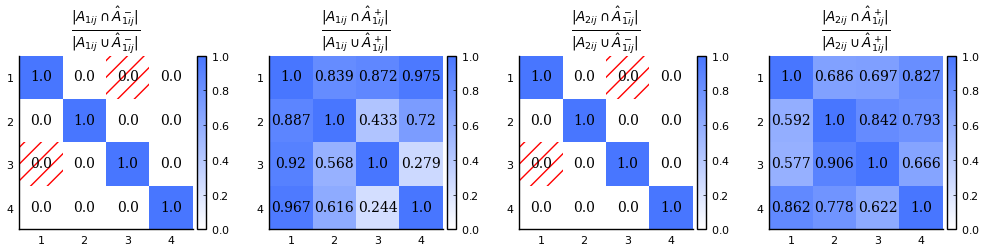

"非対角成分の算術平均: 0.0, 0.693, 0.0, 0.737"

"整合化しながら結合した重要度を求めて二重区間PCMにする"

"\$\\hat{A}_{2} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\left[ 1.822, 2.231 \\right], 2.358 \\right] & \\left[ 3.102, \\left[ 3.746, 4.045 \\right], 5.231 \\right] & \\left[ 3.598, \\left[ 3.927, 4.502 \\right], 4.692 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht], 1.338 \\right] \\\\ \\left[ 0.213, \\left[ 0.222, 0.255 \\right], 0.278 \\right] & \\left[ 0.377, \\left[ 0.437, 0.526 \\right],  0.58 \\right] & \\left[ 0.747, \\left[ 0.898, 0.954 \\right], 1.286 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

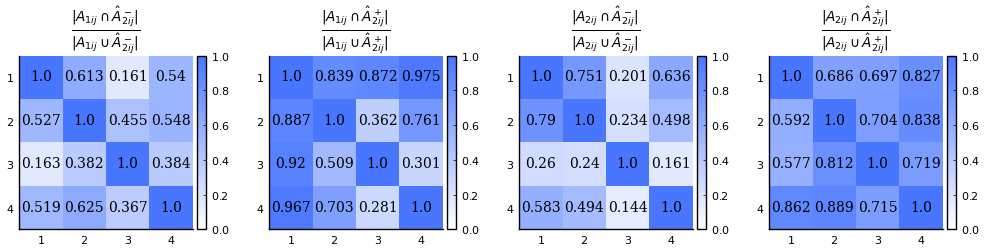

"非対角成分の算術平均: 0.44, 0.698, 0.416, 0.743"

"DMごとに重要度の上・下近似を求めて重要度として結合し，二重区間PCMにする"

"\$\\hat{A}_{3} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 2.056, \\left[ 2.064, 2.208 \\right], 2.254 \\right] & \\left[ 3.659, \\left[ 3.674, 3.746 \\right], 4.959 \\right] & \\left[  3.97, \\left[ 4.202, 4.502 \\right], 4.588 \\right] \\\\ \\le" ⋯ 449 bytes ⋯ "ht],  1.23 \\right] \\\\ \\left[ 0.218, \\left[ 0.222, 0.238 \\right], 0.252 \\right] & \\left[ 0.457, \\left[ 0.457, 0.531 \\right], 0.556 \\right] & \\left[ 0.813, \\left[ 0.813, 0.891 \\right], 1.249 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

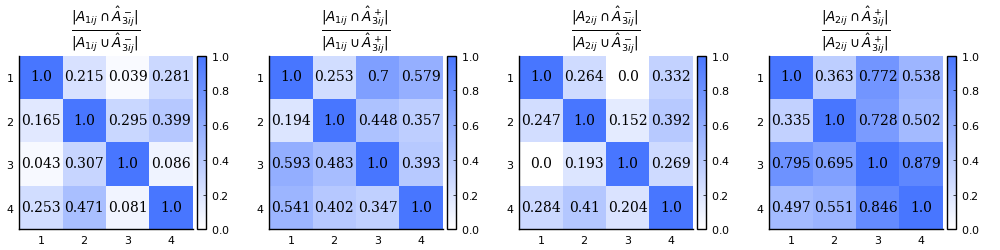

"非対角成分の算術平均: 0.22, 0.441, 0.229, 0.625"

"DMごとに重要度の上・下近似を求めて二重区間PCMにして，一つの二重区間PCMに結合して整合化"

"\$\\hat{A}_{4} = \\begin{bmatrix} \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] & \\left[ 1.564, \\emptyset, 2.358 \\right] & \\left[ 3.102, \\emptyset, 5.231 \\right] & \\left[ 3.598, \\emptyset, 4.692 \\right] \\\\ \\left[ 0.424, \\emptyset, 0.639 \\right] & \\left[   1.0, \\l" ⋯ 233 bytes ⋯ "0,   1.0 \\right],   1.0 \\right] & \\left[ 0.688, \\emptyset, 1.381 \\right] \\\\ \\left[ 0.213, \\emptyset, 0.278 \\right] & \\left[ 0.365, \\emptyset, 0.655 \\right] & \\left[ 0.724, \\emptyset, 1.454 \\right] & \\left[   1.0, \\left[   1.0,   1.0 \\right],   1.0 \\right] \\end{bmatrix}\$"

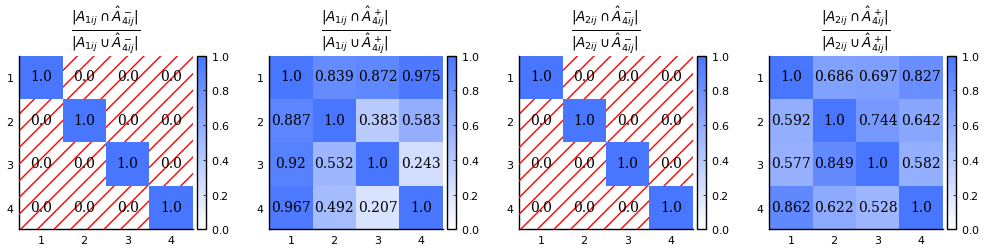

"非対角成分の算術平均: 0.0, 0.659, 0.0, 0.684"

In [44]:
A = [
    1 2 4 4
    1/2 1 2 2
    1/4 1/2 1 1
    1/4 1/2 1 1
]

A₁ = randamizedIntervalPCM(A, 14, 3e-1)
A₂ = randamizedIntervalPCM(A, 1234, 3e-1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂)

推移率が成り立つ通常の $4 \times 4$ PCM に幅を与えて整合していない行列　2 つを作る

$\begin{bmatrix} 1/2 & 2 & 4 & 4 \\ 1/2 & 1 & 2 & 2 \\ 1/4 & 1/2 & 1 & 1 \\ 1/4 & 1/2 & 1 & 1 \end{bmatrix}$ に自然対数スケールで $[0, 3]$ の一様分布に従う乱数の分だけ上下に幅をもたせている

<!-- - 2 つとも整合していない
- 幅 $0.1$ の一様分布に従う乱数をもとに自然対数スケールで幅を持たせる
- $6 \times 6$

手法 3 の挙動がおかしい

```
A = [
    1 6 5 4 8 8
    1/6 1 2 2 6 4
    1/5 1/2 1 2 7 3
    1/4 1/2 1/2 1 6 5
    1/8 1/6 1/7 1/6 1 2
    1/8 1/4 1/3 1/5 1/2 1
]

A₁ = randamizedIntervalPCM(A, 234, 0.1)
A₂ = randamizedIntervalPCM(A, 134, 0.1)

display(L"A_1 = %$(intervalMatrixLaTeXString(A₁))")
display(L"A_2 = %$(intervalMatrixLaTeXString(A₂))")

display(isWeaklyConsistentIntervalPCM(A₁))
display(isWeaklyConsistentIntervalPCM(A₂))

plotAll(A₁, A₂, (1600, 400))
``` -->

### 指数が 0 の場合のヒートマップの見方

- 斜線なし
    - $\hat{A}_{ij}^-$ が点 ($a_{ij}^{\text{L}-} = a_{ij}^{\text{U}-}$) で， $\hat{A}_{ij}^- \subset A_{kij}$
- 斜線あり
    - $A_{kij} \cap \hat{A}_{ij}^- = \emptyset$
        - $\hat{A}_{ij}^- \neq \emptyset$ で $A_{ij}^-$ が $A_{kij}$ と重なっていない
        - $\hat{A}_{ij}^- = \emptyset$

### 考察

- 同じ行列を 2 つ入れた場合について
    - 前述の意味で整合している区間 PCM を入力したが整合化で PCM が更新される
    - 内と元の区間の一致度
        - 2 > 1 = 4 > 3
            - 2 以外は点に $A_{kij}$ と $\hat{A}_{ij}^-$ がともに点で，それらが一致した場合に指数を 1 とする処理によって差がついている
                - 1, 3, 4 の中で 3 だけ $(3, 4), (4, 3)$ 成分の区間が幅を持っていた
    - 外と元の区間の一致度
        - 2 > 1 = 4 > 3
            - 3 以外は僅差
                - 3 だけ $k = 1, 2$ ともに 0.2 程度しかない
                - 1, 2, 4 は $k = 1, 2$ ともに 0.61 ~ 0.65 程度
---
- 整合していて各成分に包含関係が成り立つ場合について
    - 結合後の二重区間の内は，元の区間の狭い方よりも狭く，二重区間の外は元の区間の広い方よりも広くなっている
    - 手法 4 が空集合ばかりになっている
        - 最初に各 DM の重要度の上近似・下近似を求めるところで下近似が点になり ($w_k^{\text{L}-} = w_k^{\text{U}-}$) ，それらの共通部分を取るので空集合になる
    - 内と元の区間の一致度
        - 2 > 3 > 1 = 4
            - 2 > 3 は大きく差がついている
    - 外と元の区間の一致度
        - 1 > 2 > 4 > 3
            - 4 > 3 以外は僅差
                - $k = 1$
                    - 全て 0.4 ~ 0.43 程度
                - $k = 2$
                    - 3 が 0.44 で，他は 0.62 ~ 0.65 程度
---
- 推移率が成り立つ通常の PCM からランダムに幅を付けた場合 (幅 0.03)
    - 手法 4 が空集合ばかりになっている
        - 理由は上同
    - 内と元の区間の一致度
        - 2 > 3 > 1 = 4
            - 1, 4　は 0
                - 1 は $(1, 3), (3, 1)$ 成分が空集合で残りが点に， 4 は内が全て空集合になった
                - 2　は 0.19 程度
    - 外と元の区間の一致度
        - $k = 1$
            - 2 > 1 > 4 > 3
                - 全て 0.77 程度で僅差
        - $k = 2$
            - 3 > 1 > 2 > 4
                - 3 は 0.744, 1, 2 は 0.61 程度, 4 は 0.582
---
- 推移率が成り立つ通常の PCM からランダムに幅を付けた場合 (幅 0.3)
    - 手法 4 が空集合ばかりになっている
        - 理由は上同
    - 内と元の区間の一致度
        - 2 > 3 > 1 = 4
            - 1,4 はともに 0
                - 幅小さめのときと同じ
            - 2 は幅小さめのときよりも一致度低下
            - 3 は幅小さめのときよりも少しだけ一致度低下
    - 外と元の区間の一致度
        - $k = 1$
            - 2 > 1 > 4 > 3
                - 1, 2 はともに 0.7 程度, 4 は 0.66, 3 は 0.441
        - $k = 2$
            - 2 > 1 > 4 > 3
                - $k = 1$ と同じような差の開き方

- 総合してみると 2 が良い
- 内側
    - 2 の次点で 3
    - 1, 4 は点や空集合になる
- 外側
    - 1, 2 が同程度で，次点で 4

- 3 は外側の区間が他よりも狭く出る
    - 元の PCM が整合していて他の手法の一致度が高いときに比較的一致度が低いのはこれが原因

幅をつける際に用いる一様分布の幅をパラメータにしてシミュレーションする，ということを考えられる．今後の課題．

重みつけたら挙動変わる？

## **conflict resolution の図で点が見づらい**
## **元の PCM が完全整合ではない場合の例が一つ欲しい**
## **非対角成分の算術平均を取った後に， DM で算術平均を取る → 内外それぞれ順番付けができる**

todo
- conflict resolution 見やすくする
- 元が完全整合ではない例
- 手法の順位付けの整理
- SCIS 概要送る
- 卒論概要

なぜ ill-known ?  
→ この範囲については考慮すべきというのを考える．  
重要度に色々なとり方があり，正規性などがあるために基準/代替案どうしが干渉する  
→ なので区間の集合で考える